In [1]:
import kagglehub
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torchvision
import os
import torch
import torch.nn as nn
import torch.optim as optim


path = kagglehub.dataset_download("mahmoudreda55/satellite-image-classification")

print("Path to dataset files:", path)

Path to dataset files: /Users/annakim/.cache/kagglehub/datasets/mahmoudreda55/satellite-image-classification/versions/1


In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root=os.path.join(path, "data"), transform=transform)

loader = DataLoader(dataset, batch_size=32, shuffle=True)


Label: cloudy


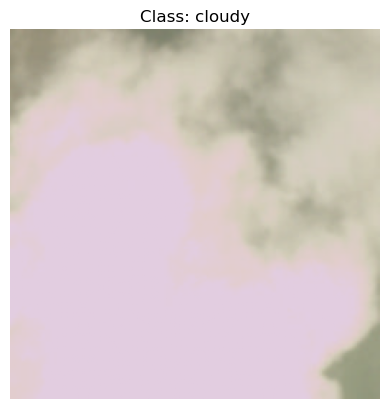

Label: cloudy


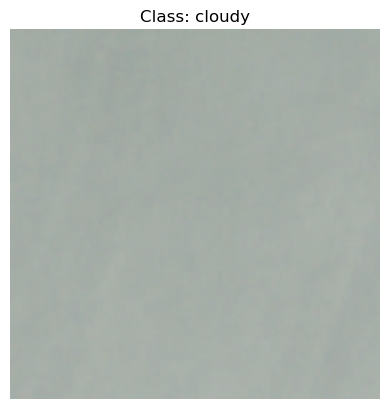

Label: cloudy


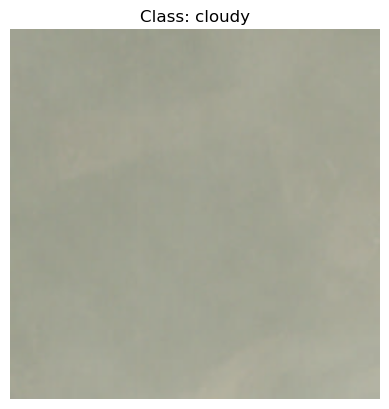

Label: cloudy


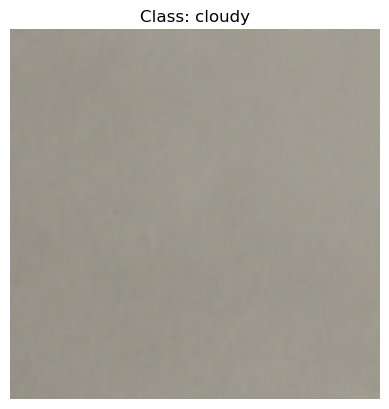

Label: cloudy


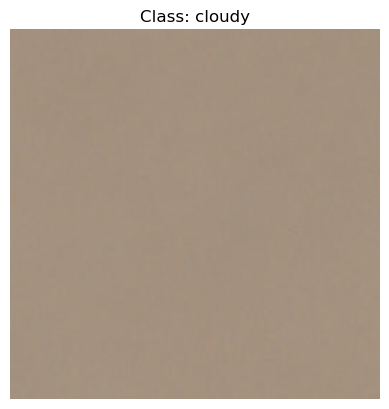

In [3]:
for i in range(5):
    image, label = dataset[i]
    print(f"Label: {dataset.classes[label]}")
    
    # Show the image
    plt.imshow(image.permute(1, 2, 0))  # convert from CxHxW to HxWxC
    plt.title(f"Class: {dataset.classes[label]}")
    plt.axis('off')
    plt.show()

In [4]:
import pandas as pd

samples = dataset.samples  

df = pd.DataFrame(samples, columns=["image_path", "label_index"])

df["class_name"] = df["label_index"].apply(lambda x: dataset.classes[x])

print(df.head())
print(dataset.classes)


                                          image_path  label_index class_name
0  /Users/annakim/.cache/kagglehub/datasets/mahmo...            0     cloudy
1  /Users/annakim/.cache/kagglehub/datasets/mahmo...            0     cloudy
2  /Users/annakim/.cache/kagglehub/datasets/mahmo...            0     cloudy
3  /Users/annakim/.cache/kagglehub/datasets/mahmo...            0     cloudy
4  /Users/annakim/.cache/kagglehub/datasets/mahmo...            0     cloudy
['cloudy', 'desert', 'green_area', 'water']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape: torch.Size([32, 3, 224, 224])


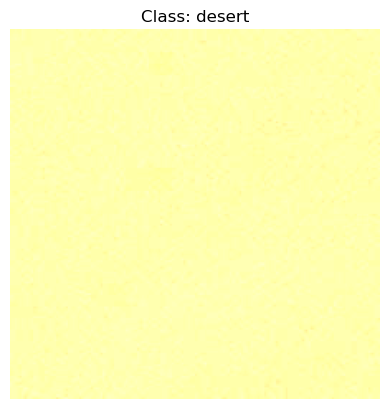

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


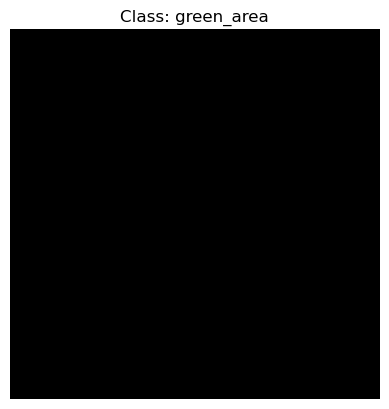

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


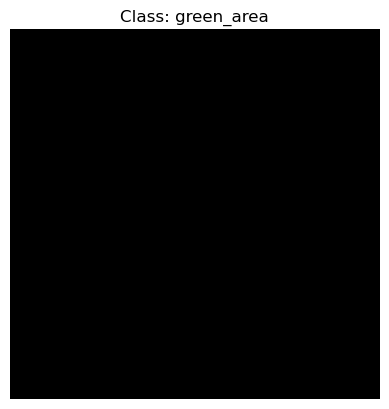

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


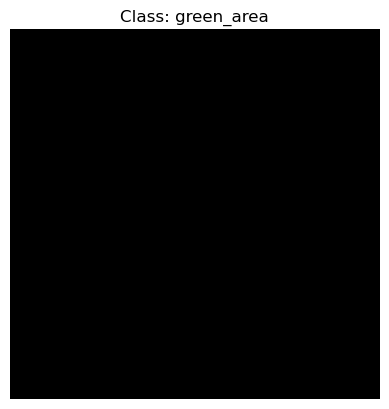

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


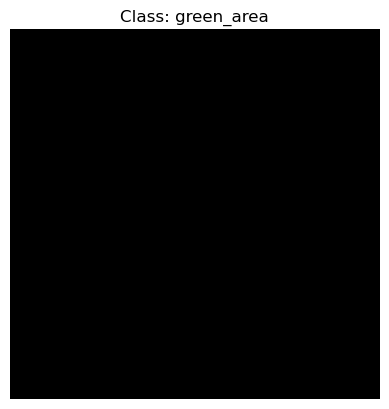

                                          image_path  label_index class_name
0  /Users/annakim/.cache/kagglehub/datasets/mahmo...            0     cloudy
1  /Users/annakim/.cache/kagglehub/datasets/mahmo...            0     cloudy
2  /Users/annakim/.cache/kagglehub/datasets/mahmo...            0     cloudy
3  /Users/annakim/.cache/kagglehub/datasets/mahmo...            0     cloudy
4  /Users/annakim/.cache/kagglehub/datasets/mahmo...            0     cloudy
Classes: ['cloudy', 'desert', 'green_area', 'water']


In [5]:
#preprocessing

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

full_dataset = datasets.ImageFolder(root=os.path.join(path, "data"), 
                                    transform=None)

train_size = int(0.8 * len(full_dataset))
valid_size = len(full_dataset) - train_size

train_dataset, valid_dataset = random_split(full_dataset, [train_size, valid_size])

train_dataset.dataset.transform = train_transform
valid_dataset.dataset.transform = valid_transform

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

sample_images, sample_labels = next(iter(train_loader))
print("Batch shape:", sample_images.shape)

for i in range(min(5, len(sample_images))):
    image = sample_images[i]
    label = sample_labels[i]
    class_name = full_dataset.classes[label]
    
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"Class: {class_name}")
    plt.axis("off")
    plt.show()

samples = full_dataset.samples 

df = pd.DataFrame(samples, columns=["image_path", "label_index"])
df["class_name"] = df["label_index"].apply(lambda x: full_dataset.classes[x])

print(df.head())
print("Classes:", full_dataset.classes)

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(in_features=64 * 28 * 28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

num_classes = len(full_dataset.classes)
model = SimpleCNN(num_classes=num_classes)

done!


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100.0 * correct / total
    
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%")

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
    val_epoch_loss = val_loss / len(valid_loader.dataset)
    val_epoch_acc = 100.0 * val_correct / val_total
    print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_acc:.2f}%")
    print("-"*60)



Epoch [1/5], Train Loss: 0.4208, Train Accuracy: 81.13%
Validation Loss: 0.2529, Validation Accuracy: 88.02%
------------------------------------------------------------
Epoch [2/5], Train Loss: 0.3114, Train Accuracy: 86.92%
Validation Loss: 0.2679, Validation Accuracy: 92.55%
------------------------------------------------------------
Epoch [3/5], Train Loss: 0.2576, Train Accuracy: 89.50%
Validation Loss: 0.2125, Validation Accuracy: 91.30%
------------------------------------------------------------
Epoch [4/5], Train Loss: 0.2473, Train Accuracy: 90.01%
Validation Loss: 0.2814, Validation Accuracy: 87.49%
------------------------------------------------------------
Epoch [5/5], Train Loss: 0.2382, Train Accuracy: 89.54%
Validation Loss: 0.2244, Validation Accuracy: 89.97%
------------------------------------------------------------


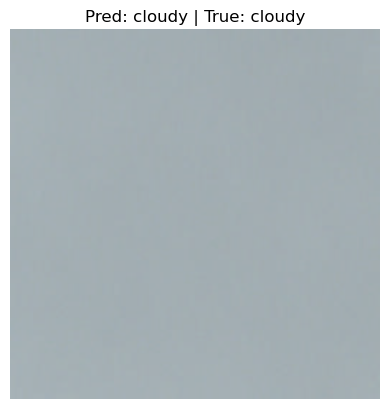

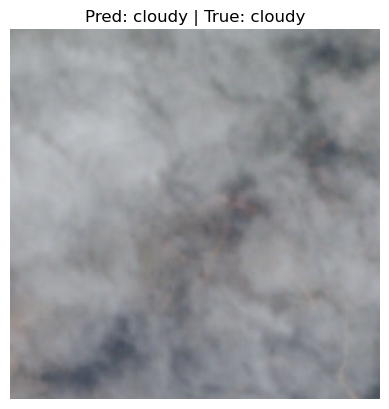

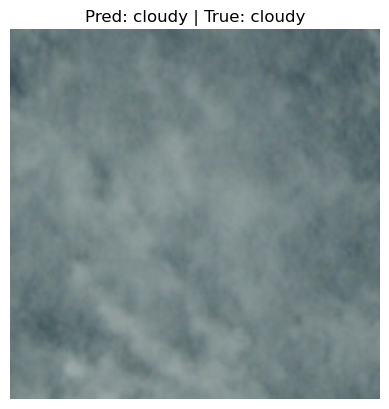

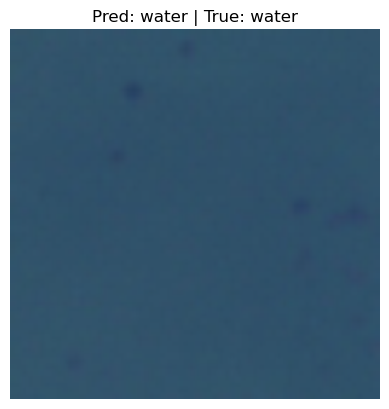

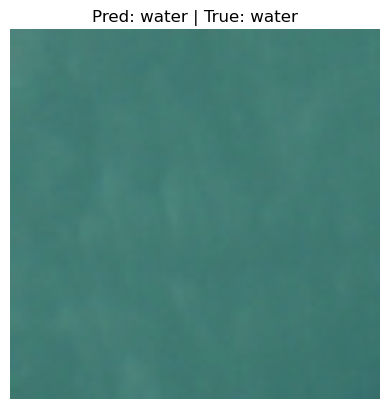

Training complete!


In [12]:
model.eval()
images, labels = next(iter(valid_loader))
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, predicted = torch.max(outputs, 1)

images = images.cpu()
predicted = predicted.cpu()
labels = labels.cpu()

for i in range(min(5, len(images))):
    plt.imshow(images[i].permute(1,2,0) * 0.229 + 0.485) 
    class_name = full_dataset.classes[predicted[i].item()]
    true_class = full_dataset.classes[labels[i].item()]
    plt.title(f"Pred: {class_name} | True: {true_class}")
    plt.axis("off")
    plt.show()


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

model.eval()  

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
prec_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy:  {acc:.4f}")
print(f"Precision (macro): {prec_macro:.4f}")
print(f"Recall (macro):    {recall_macro:.4f}")
print(f"F1-score (macro):  {f1_macro:.4f}")

Accuracy:  0.8997
Precision (macro): 0.9125
Recall (macro):    0.9049
F1-score (macro):  0.9025
